# Library

In [1]:
from pandas import read_csv
from pandas import DataFrame

from numpy import float32
from numpy import reshape
from numpy import sort

from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

from tensorflow import tensordot
from tensorflow import keras
from tensorflow import nn

from keras import regularizers
from keras import optimizers
from keras import metrics
from keras import losses
from keras import layers
from keras import Model

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import logging
import os

# For Clean Tensorflow Verbosity
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

2024-12-14 18:08:52.322494: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Data Understanding

## 1.1. Downloading Data

In [2]:
!kaggle datasets download CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
100%|█████████████████████████████████████▉| 25.0M/25.0M [00:10<00:00, 2.93MB/s]
100%|██████████████████████████████████████| 25.0M/25.0M [00:10<00:00, 2.51MB/s]


## 1.2. Extracting Data

In [3]:
!unzip anime-recommendations-database.zip

Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


## 1.3. Data Loading

In [2]:
anime_df = read_csv('./anime.csv')
rating_df = read_csv('./rating.csv')

print("Dataframe Anime")
print("Jumlah Data Anime  :", len(anime_df.anime_id.unique()))

print("\nDataframe Rating")
print("Jumlah Data Rating :", len(rating_df.user_id.unique()))
print("Jumlah Anime yang di rating", len(rating_df.anime_id.unique()))

Dataframe Anime
Jumlah Data Anime  : 12294

Dataframe Rating
Jumlah Data Rating : 73515
Jumlah Anime yang di rating 11200


## 1.5. Anime Variabel

In [3]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [5]:
print("Jumlah Anime :", len(anime_df.name.unique()))
print("Judul Anime  :", anime_df.name.unique())
print("\nJumlah Genre :", len(anime_df.genre.unique()))
print("Genre Anime  :", anime_df.genre.unique())

Jumlah Anime : 12292
Judul Anime  : ['Kimi no Na wa.' 'Fullmetal Alchemist: Brotherhood' 'Gintama°' ...
 'Violence Gekiga David no Hoshi'
 'Violence Gekiga Shin David no Hoshi: Inma Densetsu'
 'Yasuji no Pornorama: Yacchimae!!']

Jumlah Genre : 3265
Genre Anime  : ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']


## 1.6. Rating Variabel

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [8]:
print("Jumlah User     :", len(rating_df.user_id.unique()))
print("Jumlah Anime    :", len(rating_df.anime_id.unique()))
print("Panjang Rating  :", len(rating_df.rating.unique()))
print("Rentang Rating  :", sort(rating_df.rating.unique()))

Jumlah User     : 73515
Jumlah Anime    : 11200
Panjang Rating  : 11
Rentang Rating  : [-1  1  2  3  4  5  6  7  8  9 10]


In [9]:
rating_df['rating'].value_counts(sort=False)

rating
-1     1476496
 10     955715
 8     1646019
 6      637775
 9     1254096
 7     1375287
 3       41453
 5      282806
 4      104291
 1       16649
 2       23150
Name: count, dtype: int64

In [10]:
rating_df['rating'].describe()

count    7.813737e+06
mean     6.144030e+00
std      3.727800e+00
min     -1.000000e+00
25%      6.000000e+00
50%      7.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

# 2. Data Preprocessing

# 3. Data Preparation

## 3.1. Missing Value

### 3.1.1. Anime Variabel

In [11]:
anime_df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Menampilkan baris yang memiliki missing value

In [12]:
anime_df[anime_df.isnull().any(axis=1)]

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
12274,34492,Nuki Doki! Tenshi to Akuma no Sakusei Battle -...,Hentai,OVA,Unknown,NaN,392
12279,34491,Sagurare Otome The Animation,Hentai,OVA,1,NaN,79
12280,34312,Saimin Class,Hentai,OVA,Unknown,NaN,240
12282,34388,Shikkoku no Shaga The Animation,Hentai,OVA,Unknown,NaN,195


Terdapat 277 data yang memilik missing value. Karena jumlahnya sedikit maka data dengan missing value akan dihapus

In [13]:
anime_df = anime_df.dropna()

# Periksa kembali missing value
anime_df.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Sekarang dataset anime sudah bersih dari missing value

### 3.1.2. Rating Variabel

In [14]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

Tidak terdapat missing value pada dataset rating

## 3.2. Unrated Anime

In [15]:
rating_df.shape

(7813737, 3)

In [16]:
rating_df = rating_df.loc[rating_df['rating'] != -1]
rating_df.sample(5)

,user_id,anime_id,rating
5264684,49941,8425,7
5884162,54963,1015,10
2249159,21692,6746,7
1149061,11000,746,8
3389857,31207,2445,6


In [17]:
rating_df.shape

(6337241, 3)

In [18]:
rating_df.value_counts(rating_df['rating'], sort=False)

rating
1       16649
2       23150
3       41453
4      104291
5      282806
6      637775
7     1375287
8     1646019
9     1254096
10     955715
Name: count, dtype: int64

## 3.3. Label Encoding

In [21]:
rating_df.sample(10)

,user_id,anime_id,rating
6850643,63588,3588,7
1998731,19375,813,8
648057,6184,2001,9
2249891,21700,249,9
7509527,70241,13601,10
7136893,66567,850,7
1521763,14680,2759,5
531278,5335,19429,5
3620343,33704,14513,10
4653222,44515,14355,8


### 3.3.1. Anime Encoding

In [19]:
userID = rating_df['user_id'].unique().tolist()
idU2idUE = {x : i for i, x in enumerate(userID)}
idUE2idU = {i : x for i, x in enumerate(userID)}

### 3.3.2. Rating Encoding

In [20]:
animeID = rating_df['anime_id'].unique().tolist()
idA2idAE = {x : i for i, x in enumerate(animeID)}
idAE2idA = {i : x for i, x in enumerate(animeID)}

### 3.3.3.Genre Encoding

In [22]:
list_genres = sort(anime_df['genre'].str.split(', ').explode('genre').unique())
num_genre = len(list_genres)
print(num_genre)
print(list_genres)

43
['Action' 'Adventure' 'Cars' 'Comedy' 'Dementia' 'Demons' 'Drama' 'Ecchi'
 'Fantasy' 'Game' 'Harem' 'Hentai' 'Historical' 'Horror' 'Josei' 'Kids'
 'Magic' 'Martial Arts' 'Mecha' 'Military' 'Music' 'Mystery' 'Parody'
 'Police' 'Psychological' 'Romance' 'Samurai' 'School' 'Sci-Fi' 'Seinen'
 'Shoujo' 'Shoujo Ai' 'Shounen' 'Shounen Ai' 'Slice of Life' 'Space'
 'Sports' 'Super Power' 'Supernatural' 'Thriller' 'Vampire' 'Yaoi' 'Yuri']


In [101]:
genre_encode_dict = {genre : i for i, genre in enumerate(list_genres)}
genre_decode_dict = {i : genre for i, genre in enumerate(list_genres)}

In [94]:
def genre_encoding(data):
    return ' '.join([str(genre_encode_dict[genre]) for genre in data.split(', ')])

genre_encoding(anime_df['genre'].loc[0])

'6 25 27 38'

In [167]:
def genre_decoding(data):
    return ' '.join(genre_decode_dict[int(genre)] for genre in data.split())

genre_decoding(anime_df['genre'].loc[0])

'Drama Romance School Supernatural'

#### SIMPAN AJA DULU!!!

In [23]:
list_genres = sort(anime_df['genre'].str.split(', ').explode('genre').unique())
num_genre = len(list_genres)
print(num_genre)
print(list_genres)

43
['Action' 'Adventure' 'Cars' 'Comedy' 'Dementia' 'Demons' 'Drama' 'Ecchi'
 'Fantasy' 'Game' 'Harem' 'Hentai' 'Historical' 'Horror' 'Josei' 'Kids'
 'Magic' 'Martial Arts' 'Mecha' 'Military' 'Music' 'Mystery' 'Parody'
 'Police' 'Psychological' 'Romance' 'Samurai' 'School' 'Sci-Fi' 'Seinen'
 'Shoujo' 'Shoujo Ai' 'Shounen' 'Shounen Ai' 'Slice of Life' 'Space'
 'Sports' 'Super Power' 'Supernatural' 'Thriller' 'Vampire' 'Yaoi' 'Yuri']


In [24]:
def onehot_genre(data):
    # onehot = np.zeros((num_genre, 1))
    onehot = np.zeros(num_genre)

    # iterate genre in list_genres variabele
    for i, genre in enumerate(list_genres):

        # iterate genre in data variable / genre in dataframe
        for g in data.split(','):

            # assign 1 if genre from data found in list_genre
            if genre == str(g).strip(): onehot[i] = 1
        
    # Return Final one-hot encoding
    return onehot

In [25]:
genres = DataFrame([onehot_genre(anime_df['genre'][0])], index=anime_df['name'], columns=list_genres)

### 3.3.4. Mapping to Dataframe

In [184]:
rating_df['user'] = rating_df['user_id'].map(idU2idUE)
rating_df['anime'] = rating_df['anime_id'].map(idA2idAE)

In [185]:
rating_df.head()

,user_id,anime_id,rating,user,anime
47,1,8074,10,0,0
81,1,11617,10,0,1
83,1,11757,10,0,2
101,1,15451,10,0,3
153,2,11771,10,1,4


In [ ]:
anime_df['genre'] = anime_df['genre'].apply(genre_encoding)

### 3.3.5. Getting Len of User & Anime

In [28]:
num_user = len(idU2idUE)
print("Jumlah User  :", num_user)

num_anime = len(idA2idAE)
print("Jumlah Anime :", num_anime)


Jumlah User  : 69600
Jumlah Anime : 9927


### 3.3.6. Convert Rating Values to Float

In [29]:
rating_df['rating'] = rating_df['rating'].values.astype(float32)

min_rating = min(rating_df['rating'])
print("Rating Terendah:", min_rating)

max_rating = max(rating_df['rating'])
print("Rating Tertinggi:", max_rating)

Rating Terendah: 1.0
Rating Tertinggi: 10.0


## 3.4. Seleksi Fitur

In [30]:
rating_df = rating_df.sample(frac=1, random_state=22)
rating_df

,user_id,anime_id,rating,user,anime
4366382,41240,1606,8.0,38964,1756
1317633,12477,8676,10.0,11818,819
4553467,43427,15417,8.0,41025,378
6564847,60633,9041,8.0,57448,285
6021732,56512,1222,6.0,53506,843
...,...,...,...,...,...
3262624,30107,270,8.0,28474,522
203700,2050,28171,10.0,1926,86
6419002,59446,6682,8.0,56318,1041
4196926,39785,22147,7.0,37588,470


In [31]:
x = rating_df[['user', 'anime']].values
y = rating_df['rating']

print("Dimensi Fitur :", x.shape)
print("Dimensi Label :", y.shape)

Dimensi Fitur : (6337241, 2)
Dimensi Label : (6337241,)


## 3.5. Normalisasi

In [32]:
scaler = MinMaxScaler()
scaler.fit(reshape(y, (-1, 1)))
y = scaler.fit_transform(reshape(y, (-1, 1)))

## 3.6. Data Splitting

In [33]:
train_indicies = int(0.8 * rating_df.shape[0])
x_train, x_valid, y_train, y_valid = (x[:train_indicies], x[train_indicies:], y[:train_indicies], y[train_indicies:])

print("Dimensi Fitur Latih    :", x_train.shape)
print("Dimensi Label Latih    :", y_train.shape)
print("Dimensi Fitur Validasi :", x_valid.shape)
print("Dimensi Label Validasi :", y_valid.shape)

Dimensi Fitur Latih    : (5069792, 2)
Dimensi Label Latih    : (5069792, 1)
Dimensi Fitur Validasi : (1267449, 2)
Dimensi Label Validasi : (1267449, 1)


# 4. Model Development

## 4.1. Content Based Filtering

Menampung dataframe anime ke variabel "data" untuk diolah

In [122]:
data = anime_df

#### 4.1.1. TF-IDF

In [138]:
# Menambahkan [token_pattern=r'\b\w+\b'] agar TFIDF tidak melewati karakter 1 digit
tfidf = TfidfVectorizer(token_pattern=r'\b\w+\b')
tfidf.fit(data['genre'])
tfidf.get_feature_names_out()

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '4', '40', '41', '42', '5', '6', '7', '8', '9'], dtype=object)

In [139]:
matrix = tfidf.fit_transform(data['genre'])
matrix.shape

(12017, 43)

Menampilkan TFIDF matrix dalam dataframe

In [210]:
DataFrame(matrix.todense(), index=data['name'], columns=[genre_decode_dict[int(x)] for x in tfidf.get_feature_names_out()]).sample(10, axis=1).sample(10, axis=0)

,Shounen,Mecha,Ecchi,Police,Kids,Psychological,Seinen,Harem,Josei,Mystery
name,,,,,,,,,,
Shin Shounan Bakusouzoku Arakure Knight,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Shiawase Haitatsu Taneko,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Soredemo Sekai wa Utsukushii,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Toki wo Kakeru Shoujo,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Fuyu no Semi,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Cool Cool Bye,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Hello Kitty no Yuki no Joou,0.0,0.000000,0.0,0.0,0.747804,0.0,0.000000,0.0,0.0,0.0
First Love,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Ontama!,0.0,0.000000,0.0,0.0,0.000000,0.0,0.607112,0.0,0.0,0.0


### 4.1.2. Cosine Similarity

In [211]:
# dense output untuk menghemat penggunaan memory/RAM
similarity = cosine_similarity(matrix, dense_output=True)
print(similarity.shape)
similarity

(12017, 12017)


array([[1.        , 0.14692967, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14692967, 1.        , 0.188587  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.188587  , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

Menyimpan cosine similarity matrix ke dalam dataframe similarity_df

In [146]:
similarity_df = DataFrame(similarity, index=data['name'], columns=data['name'])

### 4.1.3. Getting Recommendation

In [183]:
def anime_recommendations(name, similarity_data=similarity_df, items=anime_df[['name', 'genre']], k=5):
    try:
        """
        Provides anime recommendations based on cosine similarity.

        Args:
            name (str): The name of the anime to find recommendations for.
            similarity_data (pd.DataFrame): The similarity matrix DataFrame.
            items (pd.DataFrame): The DataFrame containing anime names and genres.
            k (int): The number of recommendations to return.

        Returns:
            pd.DataFrame: A DataFrame containing the top k recommendations.
        """
        # Get the similarity scores for the given anime
        similarity_scores = similarity_data.loc[:, name]

        # Check if similarity_scores is a DataFrame and convert it to a Series if necessary
        if isinstance(similarity_scores, DataFrame):
            similarity_scores = similarity_scores.iloc[:, 0]

        # Sort the scores in descending order and get the top k indices
        # We add 1 to k to exclude the anime itself from the recommendations
        top_k_indices = similarity_scores.sort_values(ascending=False).index[0:k + 1].drop(name)

        # Get the names of the recommended anime
        closest = top_k_indices

        # Return the recommendations as a DataFrame
        recommendation = DataFrame(closest).merge(items)
        recommendation['genre'] = recommendation['genre'].apply(genre_decoding)

        return recommendation
    
    except KeyError as e:
        print("Tidak ada anime dengan judul serupa di dataset.")
        print("Input judul anime lain atau pastikan judul sudah benar")

anime_recommendations('Death Note', k=10)

,name,genre
0,Death Note Rewrite,Mystery Police Psychological Supernatural Thri...
1,Mousou Dairinin,Drama Mystery Police Psychological Supernatura...
2,Higurashi no Naku Koro ni Kai,Mystery Psychological Supernatural Thriller
3,Higurashi no Naku Koro ni Rei,Comedy Mystery Psychological Supernatural Thri...
4,Mirai Nikki (TV),Action Mystery Psychological Shounen Supernatu...
5,Mirai Nikki (TV): Ura Mirai Nikki,Action Comedy Mystery Psychological Shounen Su...
6,Higurashi no Naku Koro ni,Horror Mystery Psychological Supernatural Thri...
7,Monster,Drama Horror Mystery Police Psychological Sein...
8,AD Police,Adventure Dementia Mecha Mystery Police Psycho...
9,Higurashi no Naku Koro ni Kaku: Outbreak,Horror Mystery Psychological Thriller


## 4.2. Collaborative Filtering

In [2]:
class RecommenderNet(Model):
    def __init__(self, num_user, num_anime, embedding_size, *args, **kwargs):
        super(RecommenderNet, self).__init__(*args, **kwargs)
        self.num_user = num_user
        self.num_anime = num_anime
        self.embedding_size = embedding_size

        # User Embedding Layer
        self.user_embedding = layers.Embedding(
            num_user,
            embedding_size,
            embeddings_initializer= 'he_normal',
            embeddings_regularizer= regularizers.l2(1e-6)
        )

        # User Bias Embedding Layer
        self.user_bias = layers.Embedding(num_user, 1)

        # Anime Embedding Layer
        self.anime_embedding = layers.Embedding(
            num_anime,
            embedding_size,
            embeddings_initializer= 'he_normal',
            embeddings_regularizer= regularizers.l2(1e-6)
        )

        # Anime Bias Embedding Layer
        self.anime_bias = layers.Embedding(num_anime, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        anime_vector = self.anime_embedding(inputs[:, 0])
        anime_bias = self.anime_bias(inputs[:, 0])

        dot_matrix = tensordot(user_vector, anime_vector, 2)

        x = dot_matrix + user_bias + anime_bias

        # Activation Layer
        return nn.sigmoid(x)

In [ ]:
model = RecommenderNet(num_user, num_anime, 100)

model.compile(
    loss = losses.BinaryCrossentropy(),
    optimizer = optimizers.Adam(learning_rate=0.01),
    metrics = [metrics.RootMeanSquaredError]
)

In [44]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 512,
    epochs = 200,
    validation_data = (x_valid, y_valid)
)

Epoch 1/200
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - loss: 11592.4629 - root_mean_squared_error: 0.4942 - val_loss: 22588.9395 - val_root_mean_squared_error: 0.5192
Epoch 2/200
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 38868.1641 - root_mean_squared_error: 0.4920 - val_loss: 130197.5938 - val_root_mean_squared_error: 0.4931
Epoch 3/200
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - loss: 117497.4688 - root_mean_squared_error: 0.4755 - val_loss: 223593.3906 - val_root_mean_squared_error: 0.4621
Epoch 4/200
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - loss: 240120.8594 - root_mean_squared_error: 0.4745 - val_loss: 344901.5312 - val_root_mean_squared_error: 0.4628
Epoch 5/200
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 57s 6ms/step - loss: 365858.7812 - root_mean_squared_error: 0.4739 - val_loss: 533908.3750 - val_root_mean_squared_error: 0.4499
Epoch 6/200
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - loss: 630644.0625 - root_mean_squared_error: 0.4735 - val_loss: 838607.4375 - val_roo

# 5. Evaluation

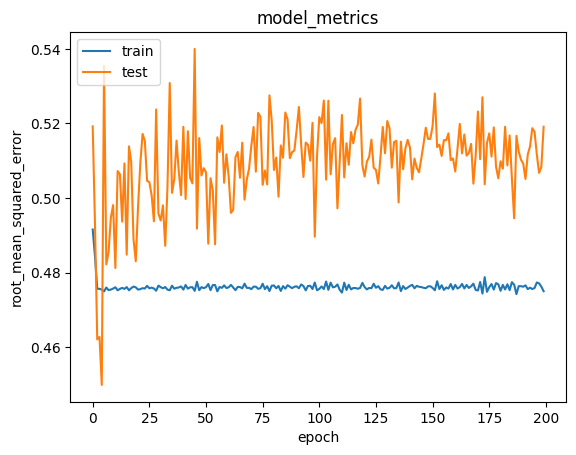

In [45]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()